# Zadatak 5 - Sentiment analysis

### Student: Vesna Stojanovic 1339

#### Korišćeni dataset: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

U ovom zadatku korišćen je dataset koji sadrži listu IMDB review-a (utisaka filmova) u kojima su korisnici komentarisali odgledane filmove. Svaki utisak sadrži komentar (utisak) i sentiment ('negative' ili 'positive'). Ovo je IMDB skup podataka sa 50.000 recenzija filmova za obradu prirodnog jezika ili analitiku teksta. 

### Pretprocesiranje

Importovanje biblioteka za rad

In [1]:
import nltk
import pandas as pd
import matplotlib.pyplot as plt

Ucitavanje skupa podataka i prikaz prvih 5 elemenata

In [2]:
reviews_df=pd.read_csv('./IMDB.csv',encoding='ISO-8859-1')
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
print("Broj utisaka: ",reviews_df.shape[0])

Broj utisaka:  50000


In [4]:
reviews_df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [5]:
reviews_df.shape

(50000, 2)

Provera null vrednosti

In [6]:
reviews_df.isnull().sum()

review       0
sentiment    0
dtype: int64

Provera vrsta sentimenata koje imamo u našem data set-u

In [7]:
reviews_df['sentiment'].unique()

array(['positive', 'negative'], dtype=object)

Provera broja sentimenata po svakom tipu sentimenta gde možemo videti da imamo 25000 pozitivnih i 25000 negativnih utisaka.

In [8]:
reviews_df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Zastupljenost sentimenta u dataset-u i vizuelni prikaz pomocu pie dijagrama

In [9]:
def value_counts_two(column):
    value = column.value_counts()
    label = column.value_counts().index
    return label, value

<AxesSubplot:>

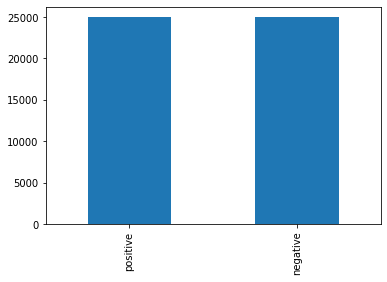

In [10]:
reviews_df.sentiment.value_counts().plot(kind = 'bar')

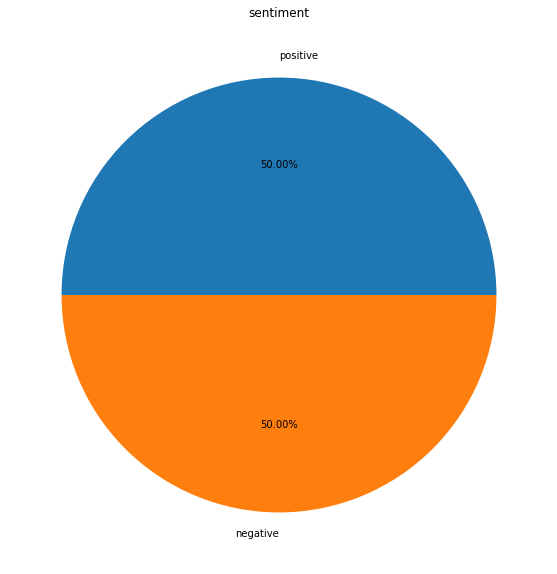

In [11]:
category_labels,category_value = value_counts_two(reviews_df['sentiment'])
fig = plt.figure(figsize =(10, 10)) 
plt.pie(category_value, labels = category_labels, autopct='%1.2f%%')
plt.title('sentiment')
plt.show()

Dodeljivanje numeričkih vrednosti sentimentima: negative=0 i positive=1

In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
label = LabelEncoder()
reviews_df['sentiment']=label.fit_transform(reviews_df['sentiment'])
reviews_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


Za nastavak analize utisaka neophodni su utisci (kolona 'review') i sentimenti koji su im dodeljeni (kolona 'sentiment').

In [14]:
X=reviews_df['review']
raw_reviews = X
Y=reviews_df['sentiment']

### Tokenizacija, eliminacija stop reči, stemovanje

In [15]:
from autocorrect import Speller
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stop_words = stopwords.words('english')
stemmer = PorterStemmer()
speller = Speller(lang='en')

Prvo se vrši tokenizacija - kreira se niz reci, potom se vrši izbacivanje svih karaktera koji nisu slova i prebacivanje u mala slova, potom se izbacuju stop reci i vrši se stemovanje, koristimo speller da ispravimo greške u rečima i na kraju spojimo sve u rečenicu.

In [16]:
cleaned_reviews=[]

for i in range(len(X)):
    review_words = word_tokenize(X.iloc[i]) 
    review_words = [word.lower() for word in review_words if word.isalpha()]
    review_words = [stemmer.stem(word) for word in review_words if (word not in stop_words)]
    reviews = ' '.join(review_words)
    cleaned_reviews.append(reviews)

In [17]:
print(reviews)

one expect star trek movi high art fan expect movi good best episod unfortun movi muddl implaus plot left cring far worst nine far movi even chanc watch well known charact interact anoth movi ca save movi includ goofi scene kirk spock mccoy br br would say movi worth rental hardli worth watch howev true fan need see movi rent movi way see even cabl channel avoid movi


### Odredjivanje sentimenta utisaka koriscenjem Sentiment Analysis iz NLTK alata

Kod određivanje sentimenta koristi se funkcija polarity_scores koja kao argument prima tekst za koji je potrebno odrediti sentiment. 
NLTK ima funkciju za direktno sentimentiranje teksta bez prethodne obrada teksta. 
A kao rezultat vraca 4 vrednosti:

pos: Verovatnoca da je sentiment pozitivan, 
neu: Verovatnoca da je sentiment neutralan,
neg: Verovatnoca da je sentiment negativan,
compound: Normalizovana suma svih rejtinga. uzima vrednosti od -1 do 1.

positive: compound score >= 0.05
neutral: compound score between -0.05 and 0.05
negative: compound score <= -0.05. 

In [18]:
from nltk.sentiment import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()
nltk_sia_results=[]

def nltk_sia(reviews):
    com = sia.polarity_scores(reviews)["compound"] 
    if com >= 0.05:
        return 1 #positive
    elif com > -0.05 and com < 0.05:
        return 2 #neutral
    else:
        return 0 #negative

for reviews in raw_reviews:
    nltk_sia_results.append(nltk_sia(reviews))

Racunanje preciznosti 

In [19]:
correct = 0

for i in range(len(Y)):
    if(Y[i]==nltk_sia_results[i]):
        correct+=1
        
print(F"{correct / len(Y):.2%} correct")

69.29% correct


### Ekstrakcija atributa korišćenjem BOW

Za ekstrakciju atributa koriscen je bag of words pristup.


In [20]:
from sklearn.feature_extraction.text import CountVectorizer
matrix = CountVectorizer(max_features=1000)
X_fin = matrix.fit_transform(cleaned_reviews).toarray()

### Naive Bayes-ov klasifikator iz NLTK alata


In [21]:
feature_names = matrix.get_feature_names_out()

def generate_features(vector):
    dictionary = {}
    for ind, number in enumerate(vector):
        key = feature_names[ind]
        dictionary[key] = number
    return dictionary

X_nltk = []
for ind, x in enumerate(X_fin):
    X_nltk.append((generate_features(x), Y[ind]))
    
train_set, test_set = X_nltk[15000:], X_nltk[:15000]

In [22]:
from nltk import NaiveBayesClassifier

classifierNLTK = NaiveBayesClassifier.train(train_set)
nltk.classify.accuracy(classifierNLTK, test_set)

0.8374666666666667

## Decision Tree klasifikator iz NLTK alata

In [ ]:
classifierDT = nltk.DecisionTreeClassifier.train(train_set)

In [ ]:
nltk.classify.accuracy(classifierDT, test_set)

### TF-IDF mera

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf = TfidfVectorizer(max_features=1000)

text_tf = tf.fit_transform(cleaned_reviews)
data=[]

for i in range(text_tf.shape[0]):
    vector = []
    for j in range(text_tf.shape[1]):
        vector.append(text_tf[i,j])
    data.append((generate_features(vector), Y[i]))

train_set, test_set = data[15000:], data[:15000]

classifier = nltk.classify.NaiveBayesClassifier.train(train_set)

nltk.classify.accuracy(classifier, test_set)